This tutorial shows how to load data that are in the biom format. Biom is a format designed to store sparse matrices that is commonly used for storing microbiome data. 

To demonstrate how to use this format, we will use `LDVAE` to analyze samples from different body sites from the Human Microbiome Project.

In [1]:
import numpy as np
from scvi.dataset import BiomDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import LDVAE
%matplotlib inline

/Users/jmorton/miniconda3/envs/scvi/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/Users/jmorton/miniconda3/envs/scvi/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


We will download a copy of the Human Microbiome Project data.  
The dimensions of a typical biom file consist of microbes along the rows and the samples long the columns.
The counts represents the number of times a microbe has been observed for a given sample.

The HMP dataset here was collected using a technique called 16S sequencing. However, the biom
format is agnostic to the data type, and is commonly used for storing metagenomics / metabolomics counts.
See https://qiita.ucsd.edu/ for more examples of downloadable studies.

In [2]:
url = r'https://github.com/biocore/American-Gut/blob/master/data/HMP/HMPv35_100nt.biom?raw=true'
biom_dataset = BiomDataset(filename='HMP.biom', url=url)

[2020-05-26 23:23:56,498] INFO - scvi.dataset.dataset | File /Users/jmorton/Documents/dev/scVI/tests/notebooks/data/HMP.biom already downloaded
[2020-05-26 23:23:56,499] INFO - scvi.dataset.biom | Preprocessing dataset
[2020-05-26 23:23:56,775] INFO - scvi.dataset.biom | Finished preprocessing dataset
7901 (7901, 6456)
[2020-05-26 23:23:56,787] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-26 23:23:56,788] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-26 23:23:56,807] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-26 23:23:56,814] INFO - scvi.dataset.dataset | Downsampled from 6456 to 6456 cells


Notice here there are 6456 samples, and many of these samples failed sequencing. These samples can be thrown out due to having low sequencing depth.  We will only focus on the top 6000 samples with the highest sequencing depths.

We will want to make sure that the number of microbes is smaller than the number of samples, so let's subsample down to 1000 microbes based on their variance.

In [3]:
biom_dataset.subsample_cells(6000)
biom_dataset.subsample_genes(1000, mode='variance')

[2020-05-26 23:23:56,837] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-26 23:23:56,843] INFO - scvi.dataset.dataset | Downsampled from 6456 to 6000 cells
[2020-05-26 23:23:56,850] INFO - scvi.dataset.dataset | Downsampling from 7901 to 1000 genes
[2020-05-26 23:23:56,861] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-26 23:23:56,865] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-05-26 23:23:56,877] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-26 23:23:56,882] INFO - scvi.dataset.dataset | Downsampled from 6000 to 6000 cells


With the biom dataset loaded, now we can load the corresponding sample metadata, this
provides sample collection information. From there we can determine which body site
each sample has originated from. This will be important for visualizing the results of the dimensionality reduction in the following step.

In [4]:
import pandas as pd
metadata_url = 'https://raw.githubusercontent.com/biocore/American-Gut/master/data/HMP/HMPv35_100nt.txt'
sample_metadata = pd.read_table(metadata_url, encoding = "ISO-8859-1", dtype='str')
sample_metadata = sample_metadata.set_index('#SampleID')
sample_metadata.head()

,BarcodeSequence,LinkerPrimerSequence,TITLE,EXPERIMENTACCESSION,sex,ANONYMIZEDNAME,pfph,HMPbodysubsite,HMPbodysupersite,intph,...,AGE,RUNALIAS,RUNCENTER,gender,REGION,srs,Runid,collectday,Description,COUNTRY
#SampleID,,,,,,,,,,,,,,,,,,,,,
SRS011182.SRX020515,TCAGAGCTTC,CCGTCAATTCMTTTRAGT,700015009,SRX020515,male,241686,0,Anterior_nares,Airways,0,...,38,no_data,WUGSC,0,V35,SRS011182,SRR045359,0,HMP_Human_metagenome_sample_700015009_from_sub...,GAZ:United States of America
SRS011296.SRX020666,TCAGTTCGCGAC,CCGTCAATTCMTTTRAGT,700015301,SRX020666,male,241748,0,Anterior_nares,Airways,0,...,27,no_data,WUGSC,0,V35,SRS011296,SRR044980,0,HMP_Human_metagenome_sample_700015301_from_sub...,GAZ:United States of America
SRS011296.SRX020669,TCAGTTCGCGAC,CCGTCAATTCMTTTRAGT,700015301,SRX020669,male,241748,0,Anterior_nares,Airways,0,...,27,no_data,WUGSC,0,V35,SRS011296,SRR045351,0,HMP_Human_metagenome_sample_700015301_from_sub...,GAZ:United States of America
SRS011380.SRX020662,TCAGTAATCTC,CCGTCAATTCMTTTRAGT,700015677,SRX020662,male,241767,0,Anterior_nares,Airways,0,...,33,no_data,WUGSC,0,V35,SRS011380,SRR047518,0,HMP_Human_metagenome_sample_700015677_from_sub...,GAZ:United States of America
SRS011380.SRX020664,TCAGTAATCTC,CCGTCAATTCMTTTRAGT,700015677,SRX020664,male,241767,0,Anterior_nares,Airways,0,...,33,no_data,WUGSC,0,V35,SRS011380,SRR045431,0,HMP_Human_metagenome_sample_700015677_from_sub...,GAZ:United States of America


Now that we have all of the relevant datasets loaded, we can build an `LDVAE` model to perform dimensionality reduction. Since we a fairly small sample size, we will train a simple model with only 1 encoder layer and 8 latent dimensions.

In [5]:
train_size = 0.5
n_latent = 8
n_layers_encoder = 1
n_hidden = 32
n_epochs = 30
latent_distribution = 'normal'
reconstruction_loss = 'nb'
learning_rate = 1e-3
gpu = False

vae = LDVAE(biom_dataset.nb_genes, biom_dataset.n_batches, biom_dataset.n_labels,
            n_latent=n_latent,
            n_layers_encoder=n_layers_encoder,
            n_hidden=n_hidden,
            reconstruction_loss=reconstruction_loss,
            latent_distribution=latent_distribution)
trainer = UnsupervisedTrainer(vae, biom_dataset, train_size=train_size,
                              frequency=1, use_cuda=gpu)
trainer.train(n_epochs=n_epochs)

[2020-05-26 23:23:58,045] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-05-26 23:23:58,046] INFO - scvi.inference.inference | KL warmup for 400 epochs



[2020-05-26 23:24:44,933] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


Once the model is fit, we can evaluate the elbo to see if the convergence has been reached.

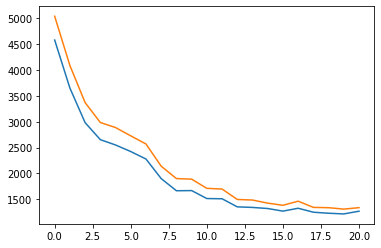

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(trainer.history['elbo_train_set'][10:])
ax.plot(trainer.history['elbo_test_set'][10:])

Our model fit looks reasonable, so we can proceed to extract the learned latent dimensions from `LDVAE` and construct an embedding using UMAP.

In [7]:
from umap import UMAP
full = trainer.create_posterior(trainer.model, biom_dataset, 
                                indices=np.arange(len(biom_dataset)))

res = full.sequential().get_latent()
reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.5)
embedding = reducer.fit_transform(res[0])

To identify which embedding coordinates correspond to which samples, 
we will need to retrieve the sample information.  Since we only looked at the top 6000 samples
with the largest sequencing depths, we will utilize the biom library to extract these samples.

In [8]:
import os
from biom import load_table

biom_path = os.path.join(biom_dataset.save_path, 
                         biom_dataset.filenames[0])
table = load_table(biom_path)
table_depths = pd.Series(table.sum(axis='sample'), index=table.ids())
sample_names = table_depths.sort_values(ascending=False)[:6000].index

embed_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=sample_names)

These embeddings can now be directly visualized in a 2D plot. We will overlay the body site information on top.

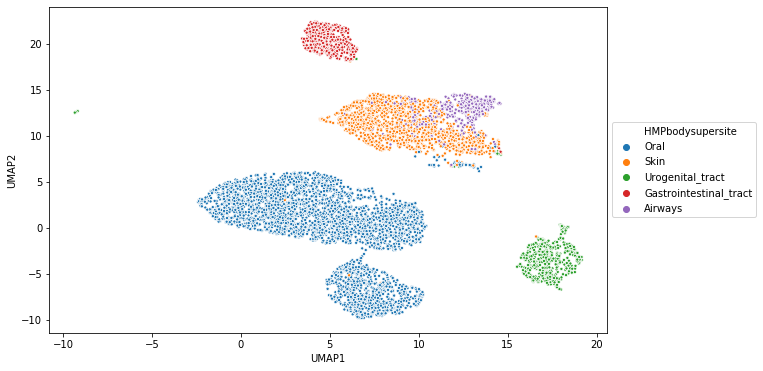

In [9]:
import seaborn as sns

# Merge sample metadata with embedding coordinates
plot_data = pd.merge(embed_df, sample_metadata, left_index=True, right_index=True)

# Plot by body site
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', 
                hue='HMPbodysupersite', s=10, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))